# Generate 1D bathymetry profile of SSA rock
Take 1D transect of Asilomar 2022 SSA rock for use in wave dissipation Matlab code by Johanna Rosman.

In [104]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy.io import loadmat, savemat
from datetime import datetime as DT
import cmocean
import matplotlib.pyplot as plt
# Interactive plots
%matplotlib widget 

# Paths, files
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_50cm.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

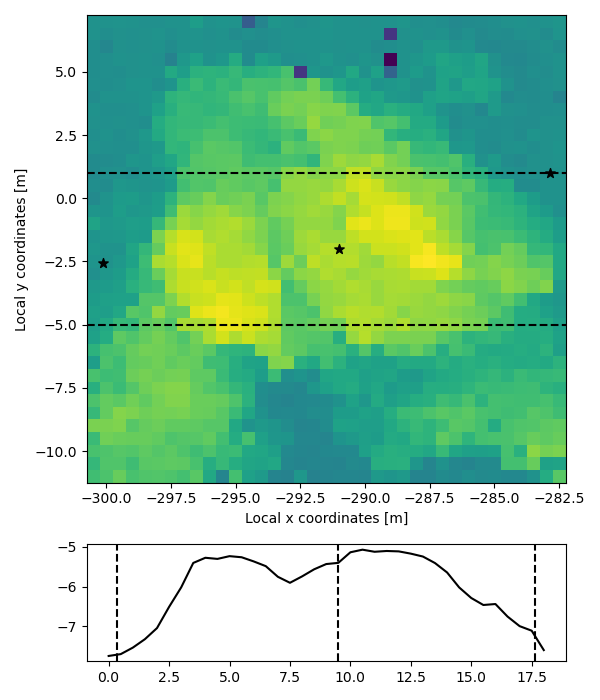

x_c1-xmin:  0.3543679822445256
x0-xmin:  9.5
x_c6-xmin:  17.64202826346542


In [61]:
# Plot bathymetry
fig, axes = plt.subplots(figsize=(6,7), nrows=2, height_ratios=[4,1])
# Set zoom in region
x0 = dsb.C3.attrs['x_loc'].round() # C3 mooring location in the middle
y0 = dsb.C3.attrs['y_loc'].round()
xmin = x0 - 9.5
xmax = x0 + 8.5
ymin = y0 - 9
ymax = y0 + 9
dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin, ymax)).plot.pcolormesh(ax=axes[0], 
                                                                        add_colorbar=False,
                                                                        )
# Mark C1, C3 & C6 moorings
axes[0].scatter(x0, y0, marker='*', color='k', s=50) # C3
x_c1, y_c1 = (dsb.C1.attrs['x_loc'], dsb.C1.attrs['y_loc'])
axes[0].scatter(x_c1, y_c1, marker='*', color='k', s=50) # C1
x_c6, y_c6 = (dsb.C6.attrs['x_loc'], dsb.C6.attrs['y_loc'])
axes[0].scatter(x_c6, y_c6, marker='*', color='k', s=50) # C6
# Take 1D transect and plot on bottom row
ymin_t = y0 - 3
ymax_t = y0 + 3
transect = dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin_t, ymax_t)).mean(dim='y')
# Make x axis for transect
xt = transect.x.values - xmin
ax=axes[1].plot(xt, transect.values, color='k')
# Mark boundaries of transect
axes[0].axhline(ymin_t, color='k', ls='--')
axes[0].axhline(ymax_t, color='k', ls='--')
# Mark mooring locations with vertical lines
axes[1].axvline(x_c1-xmin, color='k', ls='--')
axes[1].axvline(x0-xmin, color='k', ls='--')
axes[1].axvline(x_c6-xmin, color='k', ls='--')

plt.tight_layout()
plt.show()

print('x_c1-xmin: ', x_c1-xmin)
print('x0-xmin: ', x0-xmin)
print('x_c6-xmin: ', x_c6-xmin)

Save 1D transect to .mat file

In [62]:
# Save to .mat
fn_mat = os.path.join(bathydir, 'transect_1d.mat')
if not os.path.isfile(fn_mat):
    print('Saving to .mat')
    # Note: positive z
    savemat(fn_mat, {'x': xt, 'z': (transect - transect.min().item()).values})

Saving to .mat


Generate .mat file with boundary values from C1 Signature AST spectra for dissipation computation Matlab script.

In [76]:
ser = '103088'
mid = 'C1'
sig_root = os.path.join(rootdir, 'Signatures', 'Level1')
# Spectra netcdf directory
specdir = os.path.join(sig_root, '{}'.format(ser), 'Spectra') 
fn_nc_spec = os.path.join(specdir, 'Asilomar_2022_SSA_Signature_{}_spec_AST.nc'.format(ser))
dss = xr.decode_cf(xr.open_dataset(fn_nc_spec, decode_coords='all'))

# Get variables needed for boundary values
ds_c1 = np.array([pd.Timestamp(t).strftime('%Y%m%d') for t in dss.time.values])
ts_c1 = np.array([pd.Timestamp(t).strftime('%H%M') for t in dss.time.values])
Hrms_c1 = 0.5 * np.sqrt(2) * dss.Hm0.values # RMS wave heights
h_c1 = dss.depth_loc.values # Local water depths
Tp_c1 = dss.Tp_Y95.values

# Save as .mat
fn_mat_vars = os.path.join(bathydir, 'C1_Sig_input.mat')
if not os.path.isfile(fn_mat_vars):
    print('Saving to .mat')
    # Note: positive z
    savemat(fn_mat_vars, {'ds_c1':ds_c1, 'ts_c1':ts_c1, 'Hrms_c1':Hrms_c1, 
                          'h_c1':h_c1, 'Tp_c1':Tp_c1})

Saving to .mat


Combine Matlab output (12000 .mat files...) into one xr.Dataset and save as netcdf.

In [143]:
matdir = '/home/mikapm/Github/wave_dissipation_module/out'
# List all .mat files
fns_mat = sorted(glob.glob(os.path.join(matdir, 'diss_*.mat')))
# Initialize arrays
times = []
# Range of friction factor values
Cfs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
                1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]) 
Hrms = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan # Predicted Hrms profiles
D_br = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan # Predicted wave-breaking diss. profiles
D_fr = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan # Predicted bottom-frict. diss. profiles
# Initialize xr.Dataset
ds = xr.Dataset(
    data_vars=dict(
        Hrms=(['time', 'x', 'Cf'], Hrms),
        D_br=(['time', 'x', 'Cf'], D_br),
        D_fr=(['time', 'x', 'Cf'], D_fr),
    ),
    coords=dict(
        time=(['time'], dss.time.values),
        x=(['x'], xt),
        Cf=(['Cf'], Cfs),
    ),
)

# Iterate over .mat files and populate arrays
for fnm in fns_mat:
    # Get friction coefficient from filename
    Cf = float(fnm.split('_')[-1][:3])
    # Get time stamp from filename
    t = pd.Timestamp(DT.strptime(' '.join(fnm.split('_')[-4:-2]), '%Y%m%d %H%M'))
    # Append timestamp to list
    times.append(t)
    # Read .mat file and get variables
    mat = loadmat(fnm)
    Hrms = mat['S']['Hrms'].item().squeeze()
    D_br = mat['S']['Db'].item().squeeze()
    D_fr = mat['S']['Df'].item().squeeze()
    # Populate variables
    ds.Hrms.loc[dict(time=t, Cf=Cf)] = Hrms
    ds.D_br.loc[dict(time=t, Cf=Cf)] = D_br
    ds.D_fr.loc[dict(time=t, Cf=Cf)] = D_fr

# Save dataset to netcdf

print('Done.')

Done.


In [144]:
ds

<xarray.Dataset>
Dimensions:  (time: 637, x: 37, Cf: 20)
Coordinates:
  * time     (time) datetime64[ns] 2022-06-24T11:00:00 ... 2022-07-20T23:00:00
  * x        (x) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 16.0 16.5 17.0 17.5 18.0
  * Cf       (Cf) float64 0.1 0.2 0.3 0.4 0.5 0.6 ... 1.5 1.6 1.7 1.8 1.9 2.0
Data variables:
    Hrms     (time, x, Cf) float64 0.8405 0.8405 0.8405 ... 0.7402 0.7375 0.7348
    D_br     (time, x, Cf) float64 5.708e-05 5.708e-05 5.708e-05 ... 0.0 0.0 0.0
    D_fr     (time, x, Cf) float64 0.001949 0.003898 0.005848 ... 0.0 0.0 0.0